# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
def gen_tp_data(n=400, noise_sd=0.3, grid=False, seed=1):
    """
    Generate test data for tensor-product smooths.

    Parameters
    ----------
    n : int
        Number of samples (if grid=False).
    noise_sd : float
        Standard deviation of Gaussian noise.
    grid : bool
        If True, generate approximately n points on a regular grid.
        If False, generate random design points.
    seed : int
        Random seed.

    Returns
    -------
    pandas.DataFrame with columns: x, y, eta (signal), z (noisy response)
    """
    rng = np.random.default_rng(seed)

    # --- Design ----
    if grid:
        m = int(np.ceil(np.sqrt(n)))
        xs = np.linspace(0, 1, m)
        ys = np.linspace(0, 1, m)
        x, y = np.meshgrid(xs, ys, indexing="xy")
        x = x.ravel()
        y = y.ravel()
    else:
        x = rng.uniform(0, 1, n)
        y = rng.uniform(0, 1, n)

    # --- True non-separable smooth ----
    def f_true(x, y):
        return (
            1.5 * np.sin(2 * np.pi * x) * np.cos(3 * np.pi * y)
            + 0.8 * x * y
            + 2.0 * np.exp(-(((x - 0.65) ** 2) / 0.01 + ((y - 0.35) ** 2) / 0.06))
        )

    eta = f_true(x, y)
    z = eta + rng.normal(scale=noise_sd, size=len(eta))

    return pd.DataFrame({"x": x, "y": y, "eta": eta, "z": z})

In [3]:
df = gen_tp_data(n=600, noise_sd=0.25, grid=False, seed=42)
print(df.head())

          x         y       eta         z
0  0.773956  0.477506  0.935849  0.689560
1  0.438878  0.761433  0.621075  0.405865
2  0.858598  0.903328  1.334100  1.948456
3  0.697368  0.720696 -0.674870 -0.224435
4  0.094177  0.963211 -0.714339 -0.817277


In [4]:
df_grid = gen_tp_data(n=5000, grid=True)

In [5]:
df_grid

x    y           eta         z
0     0.000000  0.0  1.162528e-19  0.103675
1     0.014286  0.0  1.344590e-01  0.380944
2     0.028571  0.0  2.678353e-01  0.366966
3     0.042857  0.0  3.990553e-01  0.008108
4     0.057143  0.0  5.270622e-01  0.798669
...        ...  ...           ...       ...
5036  0.942857  1.0  1.281348e+00  1.076909
5037  0.957143  1.0  1.164770e+00  1.171729
5038  0.971429  1.0  1.044978e+00  1.027468
5039  0.985714  1.0  9.230304e-01  0.818835
5040  1.000000  1.0  8.000000e-01  0.129013

[5041 rows x 4 columns]

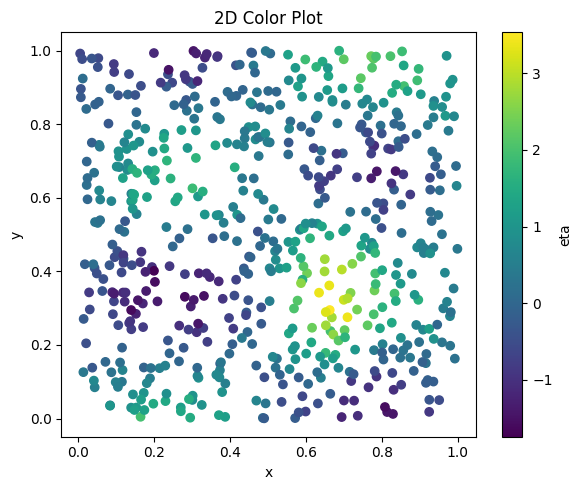

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df["x"], df["y"], c=df["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

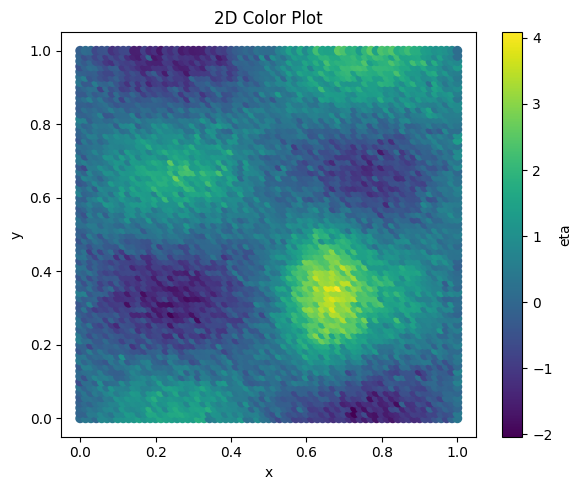

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

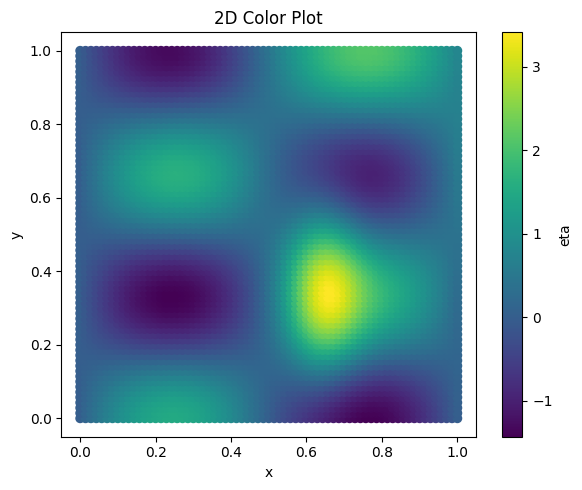

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["eta"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [9]:
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [10]:
loc += (
    tb.ti("x", "y", bs="ps", k=10),
    tb.ps("x", k=20),
    tb.ps("y", k=20),
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="z_value").value


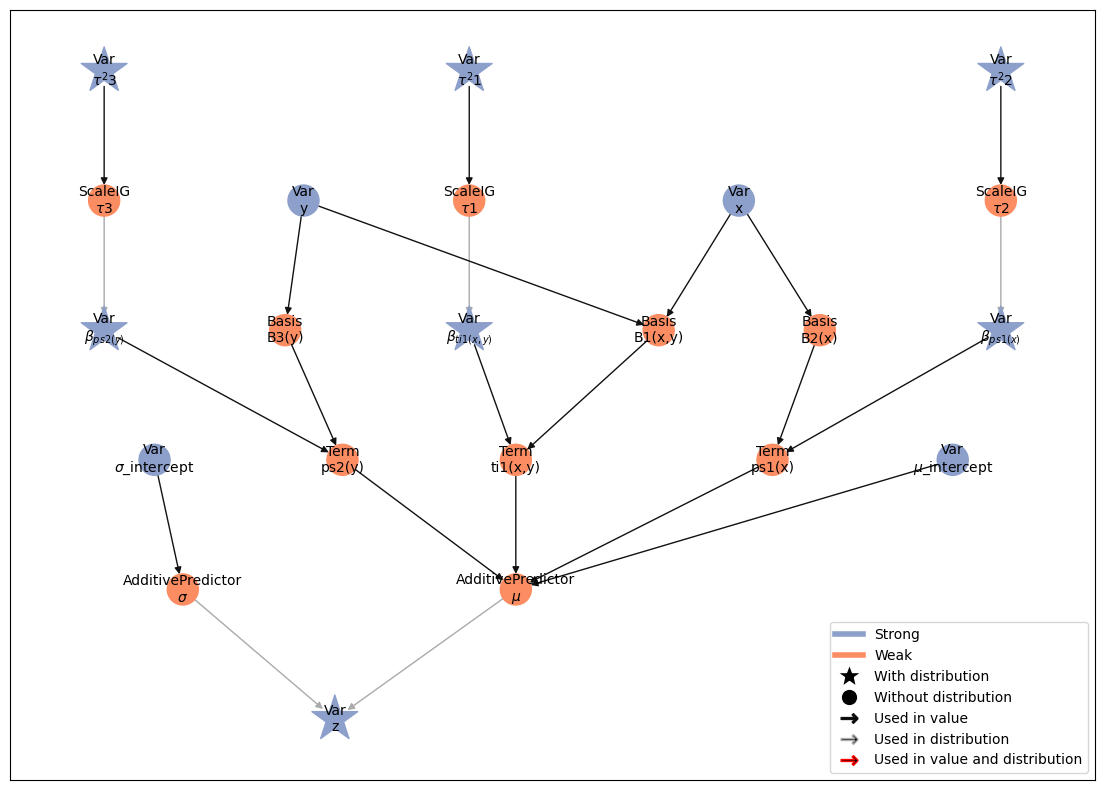

In [11]:
model = lsl.Model([z])
model.plot_vars()

## Run MCMC

In [12]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=1000,
        init_duration=200,
        term_duration=200,
        thinning_posterior=5,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{ps2(y)}$', '$\\tau^2$3', '$\\beta_{ps1(x)}$', '$\\tau^2$2', '$\\beta_{ti1(x,y)}$', '$\\tau^2$1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 200 transitions, 25 jitted together
100%|██████████████████████████████████████████| 8/8 [00:05<00:00,  1.52chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 998.17chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1350.61chunk/s]
liesel.g

### MCMC summary

In [13]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel      mean        sd    q_0.05     q_0.5  \
parameter          index                                                      
$\beta_{ps1(x)}$   (0,)   kernel_04 -0.010314  0.073618 -0.130587 -0.008951   
                   (1,)   kernel_04  0.002258  0.074671 -0.120652  0.001247   
                   (2,)   kernel_04 -0.013821  0.075843 -0.137940 -0.015984   
                   (3,)   kernel_04  0.035616  0.071395 -0.084299  0.035513   
                   (4,)   kernel_04 -0.025136  0.071532 -0.141918 -0.023880   
...                             ...       ...       ...       ...       ...   
$\mu$_intercept    ()     kernel_01  0.339119  0.011750  0.320029  0.339117   
$\sigma$_intercept ()     kernel_00 -1.345887  0.031876 -1.398245 -1.346590   
$\tau^2$1          ()     kernel_07  0.107001  0.018869  0.078828  0.105193   
$\tau^2$2          ()     kernel_05  0.006444  0.003252  0.002862  0.005744   
$\tau^2$3          ()     kernel_03  0.002298  0.001762  0.000830  0.001861   

                            q_0.95  sample_size    ess_bulk    ess_tail  \
parameter          index                                                  
$\beta_{ps1(x)}$   (0,)   0.103008          800  394.311730  584.714056   
                   (1,)   0.132673          800  455.932684  543.335913   
                   (2,)   0.110786          800  469.042030  529.127844   
                   (3,)   0.155302          800  464.245366  591.960809   
                   (4,)   0.084789          800  408.291398  579.393628   
...                            ...          ...         ...         ...   
$\mu$_intercept    ()     0.359475          800  669.441807  730.555834   
$\sigma$_intercept ()    -1.293878          800  455.679149  772.172023   
$\tau^2$1          ()     0.141735          800  439.507358  662.188165   
$\tau^2$2          ()     0.012382          800  407.613190  461.621703   
$\tau^2$3          ()     0.005055          800  305.031472  361.308430   

                              rhat  
parameter          index            
$\beta_{ps1(x)}$   (0,)   1.013771  
                   (1,)   1.004228  
                   (2,)   1.007665  
                   (3,)   1.005217  
                   (4,)   1.007954  
...                            ...  
$\mu$_intercept    ()     1.001416  
$\sigma$_intercept ()     1.009559  
$\tau^2$1          ()     1.009128  
$\tau^2$2          ()     1.004005  
$\tau^2$3          ()     1.017839  

[124 rows x 10 columns]

### MCMC trace plots

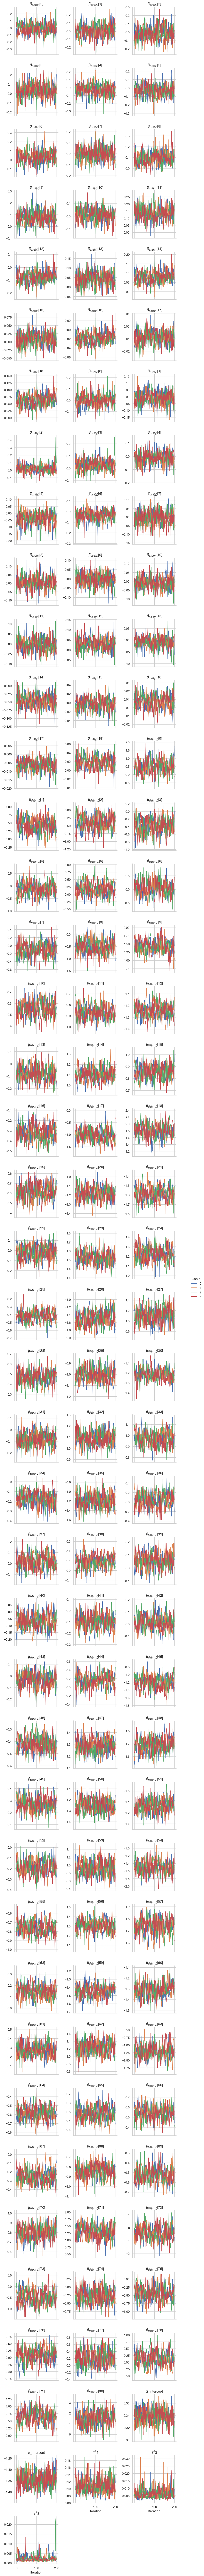

In [14]:
gs.plot_trace(results)

## Predictions

In [15]:
samples = results.get_posterior_samples()

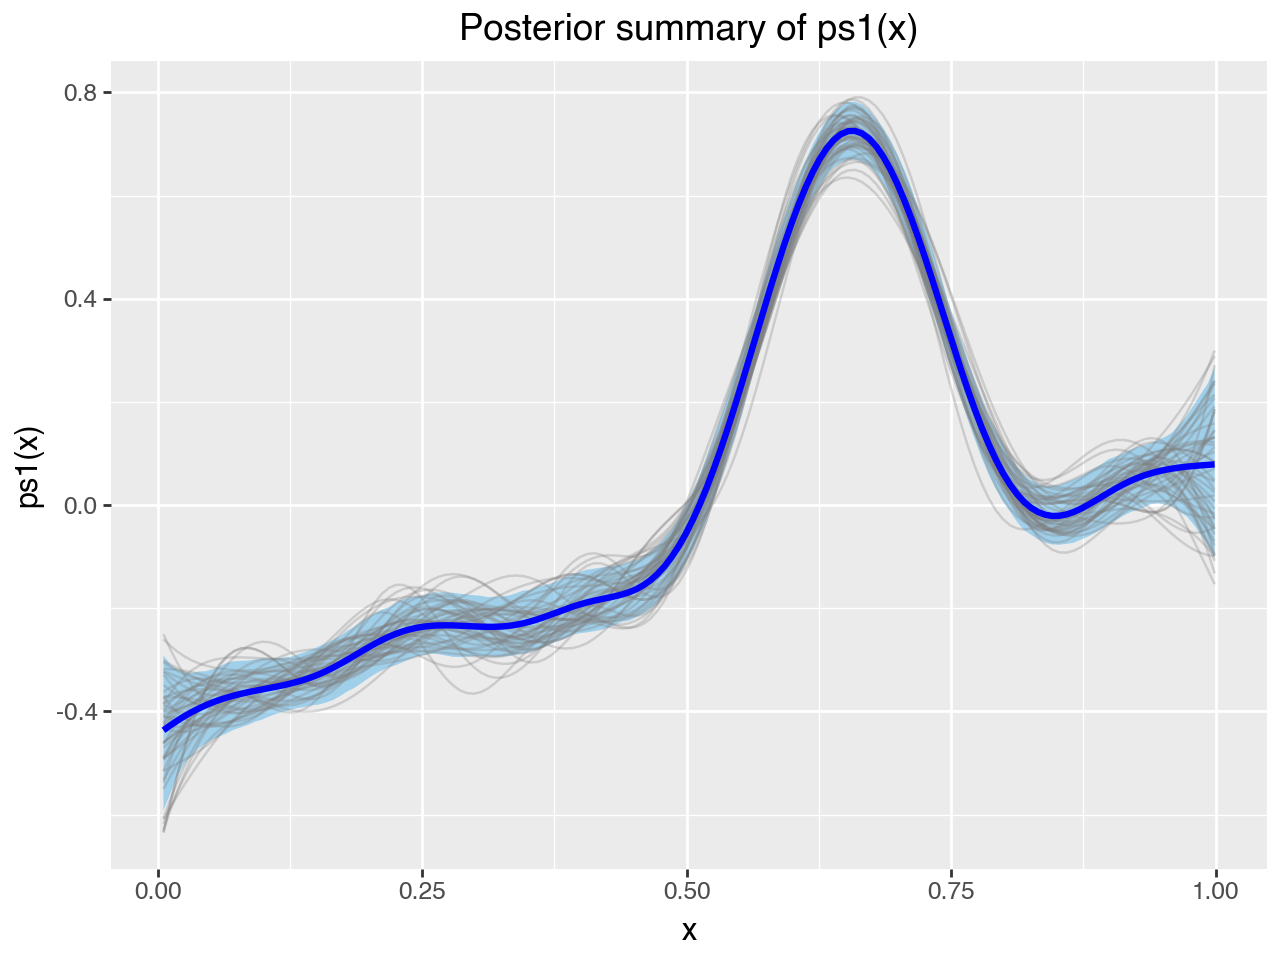

In [16]:
gam.plot_1d_smooth(term=model.vars["ps1(x)"], samples=samples)

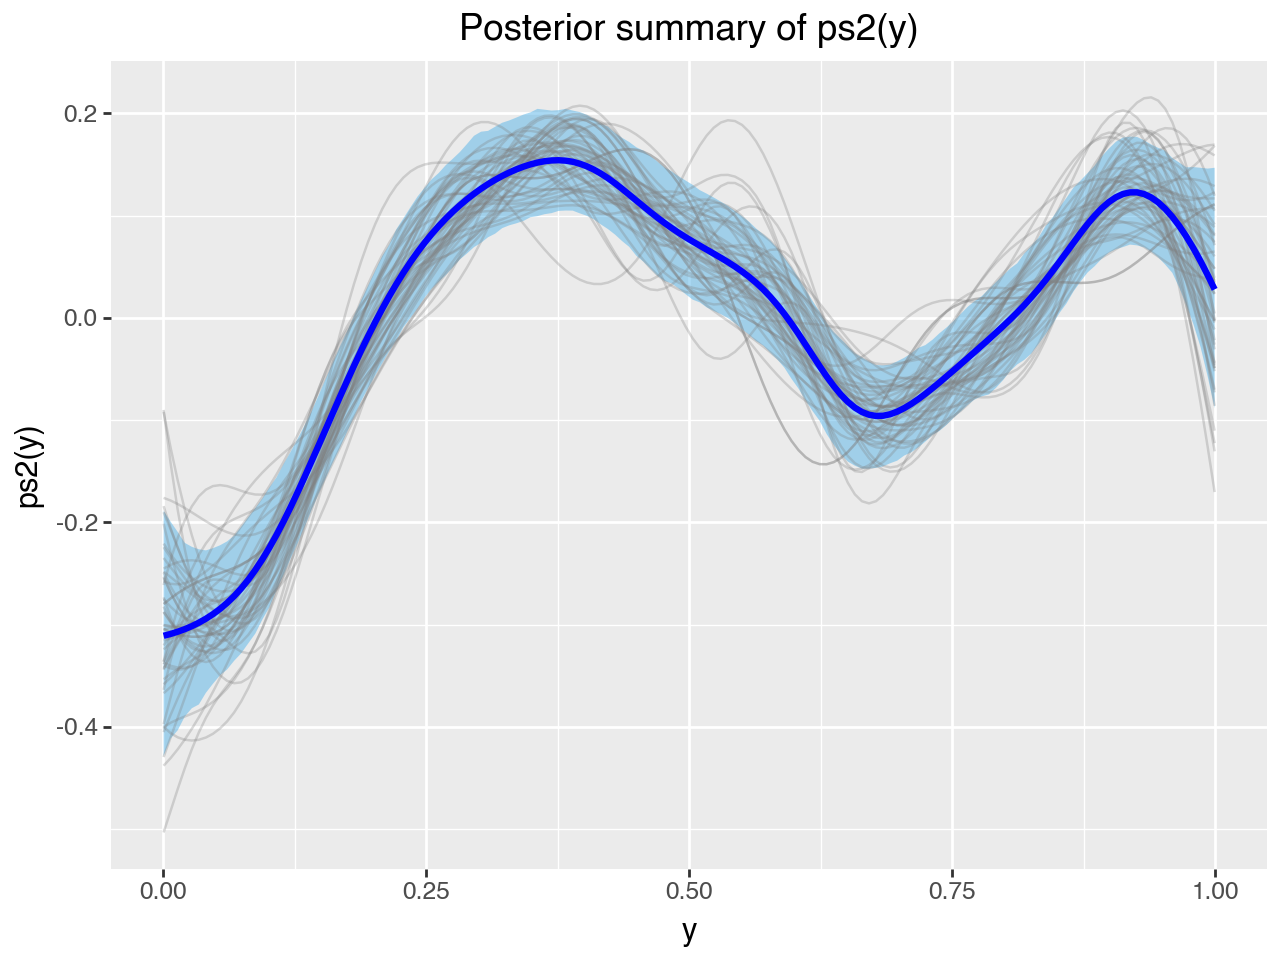

In [17]:
gam.plot_1d_smooth(term=model.vars["ps2(y)"], samples=samples)

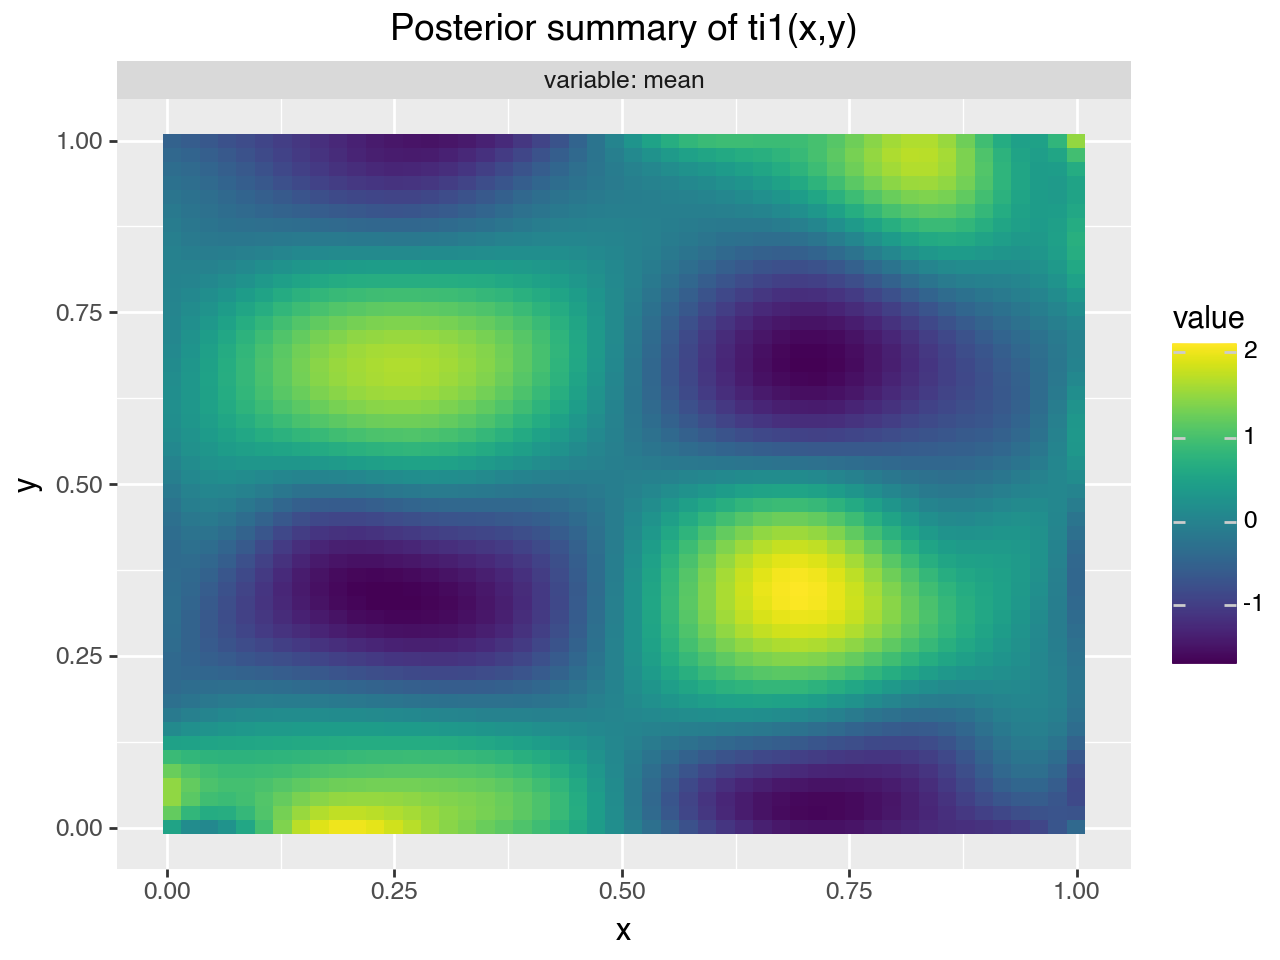

In [18]:
gam.plot_2d_smooth(
    term=loc.terms["ti1(x,y)"],
    samples=samples,
    ngrid=50,
    plot_vars=["mean"],
)

### Predict variables at new x values

In [19]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["$\\mu$"],
    newdata={"x": df_grid.x.to_numpy(), "y": df_grid.y.to_numpy()},
)

In [ ]:
predictions_summary = gs.SamplesSummary(predictions).to_dataframe().reset_index()
predictions_summary["x"] = np.tile(df_grid.x.to_numpy(), len(predictions))
predictions_summary["y"] = np.tile(df_grid.y.to_numpy(), len(predictions))
predictions_summary.head()

### Plot fitted mean

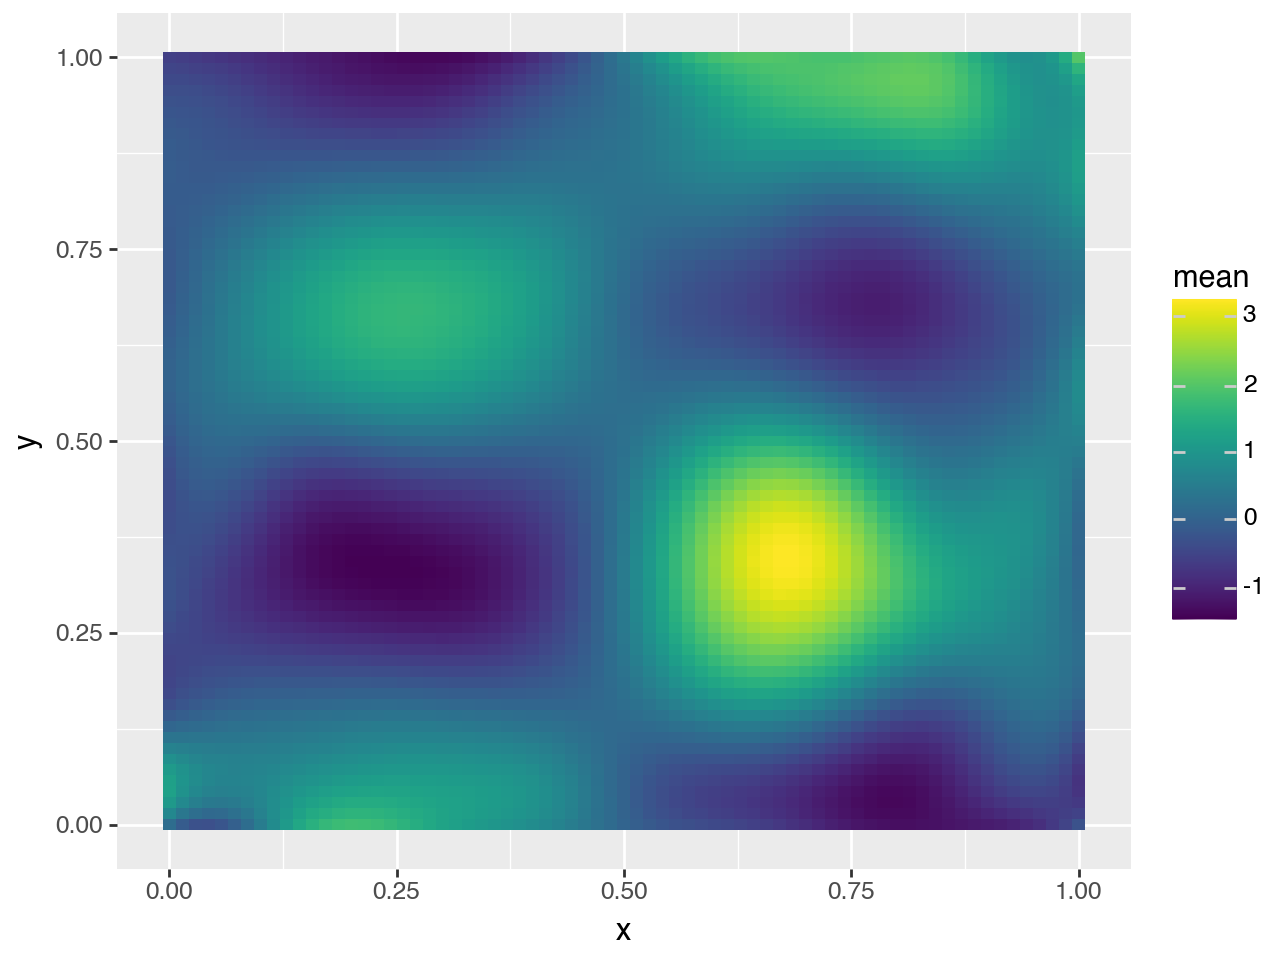

In [23]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))